In [1]:
import findspark

findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import seaborn as sb
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

dataset_root_path = "D:\\Documents\\Programming\\Python-Projects\\Clusterdata_2019_e\\"
spark = SparkSession.builder.appName('Failure Prediction on Google Borg Cluster Traces').master('local[*]').getOrCreate()

SparkContext.setSystemProperty('spark.executor.memory', '2g')
SparkContext.setSystemProperty('spark.driver.memory', '2g')

allowedEventTypes = [4, 5, 6, 7, 8]

collection_events_df = spark.read.parquet(dataset_root_path + "collection_events-*.parquet.gz")
instance_events_df = spark.read.parquet(dataset_root_path + "instance_events-*.parquet.gz")

## Common step in visualisation

In [2]:
# filter only the Jobs from the collections and the Tasks from the instances
collection_events_df = collection_events_df.filter(collection_events_df.collection_type == 0)
instance_events_df = instance_events_df.filter(instance_events_df.collection_type == 0)

collection_events_df = collection_events_df.drop("collection_type")
instance_events_df = instance_events_df.drop("collection_type")

# filter the jobs in the timeframe (between 0 and MAXINT)
collection_events_df = collection_events_df.filter((collection_events_df.time != 0) & (collection_events_df.time != (2 ^ 63 - 1)))

# filter the job ids out of the timeframe and collect to list
task_ids_to_remove_list = collection_events_df.filter((collection_events_df.time == 0) | (collection_events_df.time == (2 ^ 63 - 1))).rdd.map(lambda x: x.collection_id).collect()

# filter the tasks in the timeframe (between 0 and MAXINT), that are not part of the jobs that are outside the timeframe
instance_events_df = instance_events_df.filter((instance_events_df.collection_id.isin(task_ids_to_remove_list) == False) & (instance_events_df.time != 0) & (instance_events_df.time != (2 ^ 63 - 1)))

## Jobs Visualisation Analysis

In [3]:
# Collection Events fields with nulls: missing_type, parent_collection_id, max_per_machine, max_per_switch - fill null values; alloc_collection_id - removed
collection_events_df = collection_events_df.drop(*['user', 'collection_name', 'collection_logical_name', 'alloc_collection_id', 'start_after_collection_ids'])
collection_events_df = collection_events_df.fillna(0, subset="missing_type")
collection_events_df = collection_events_df.fillna(0, subset="parent_collection_id")
collection_events_df = collection_events_df.fillna(0, subset="max_per_machine")
collection_events_df = collection_events_df.fillna(0, subset="max_per_switch")
collection_events_df.printSchema()

root
 |-- time: long (nullable = true)
 |-- type: long (nullable = true)
 |-- collection_id: long (nullable = true)
 |-- scheduling_class: long (nullable = true)
 |-- missing_type: long (nullable = true)
 |-- priority: long (nullable = true)
 |-- parent_collection_id: long (nullable = true)
 |-- max_per_machine: long (nullable = true)
 |-- max_per_switch: long (nullable = true)
 |-- vertical_scaling: long (nullable = true)
 |-- scheduler: long (nullable = true)



#### Pie Chart

In [5]:
jobs_with_priorities_df = collection_events_df.withColumn('priority_range', F.when(collection_events_df.priority <= 99, 'Free tier').
                                                          when(collection_events_df.priority.between(100, 115), 'Best-effort Batch').when(collection_events_df.priority.between(116, 119), 'Mid-tier').
                                                          when(collection_events_df.priority.between(120, 359), 'Production tier').when(collection_events_df.priority >= 360, 'Monitoring tier')
                                                          ).select('priority_range')

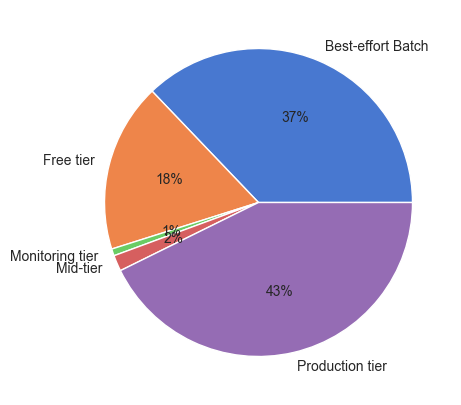

In [5]:
jobs_pie_count_rows = jobs_with_priorities_df.groupby("priority_range").count().collect()

labels = [row["priority_range"] for row in jobs_pie_count_rows]
counts = [row["count"] for row in jobs_pie_count_rows]

plt.figure(figsize = (5, 5))
plt.pie(counts, labels=labels, colors=sb.color_palette('muted'), autopct='%.0f%%')
plt.show()

#### Stacked Bar Plot - NOT USED ANYMORE

In [7]:
# collection_events_with_terminal_states_df = jobs_with_priorities_df.filter(jobs_with_priorities_df.type.isin(allowedEventTypes)).\
#                                             withColumn('type_name', F.when(jobs_with_priorities_df.type == 4, 'Evict').when(jobs_with_priorities_df.type == 5, 'Fail').
#                                                        when(jobs_with_priorities_df.type == 6, 'Finish').when(jobs_with_priorities_df.type == 7, 'Kill').
#                                                        when(jobs_with_priorities_df.type == 8, 'Lost'))
#
# jobs_stacked_bar_df = collection_events_with_terminal_states_df.select('type_name', 'priority_range').toPandas()
# jobs_stacked_bar_df = jobs_stacked_bar_df.groupby(['type_name', 'priority_range']).size().unstack()
#
# ax = jobs_stacked_bar_df.plot(kind='bar', stacked=True, figsize=(9, 6))
# plt.xlabel('')
#
# plt.xticks(rotation=0)
# plt.show()

#### Heatmap

<Axes: >

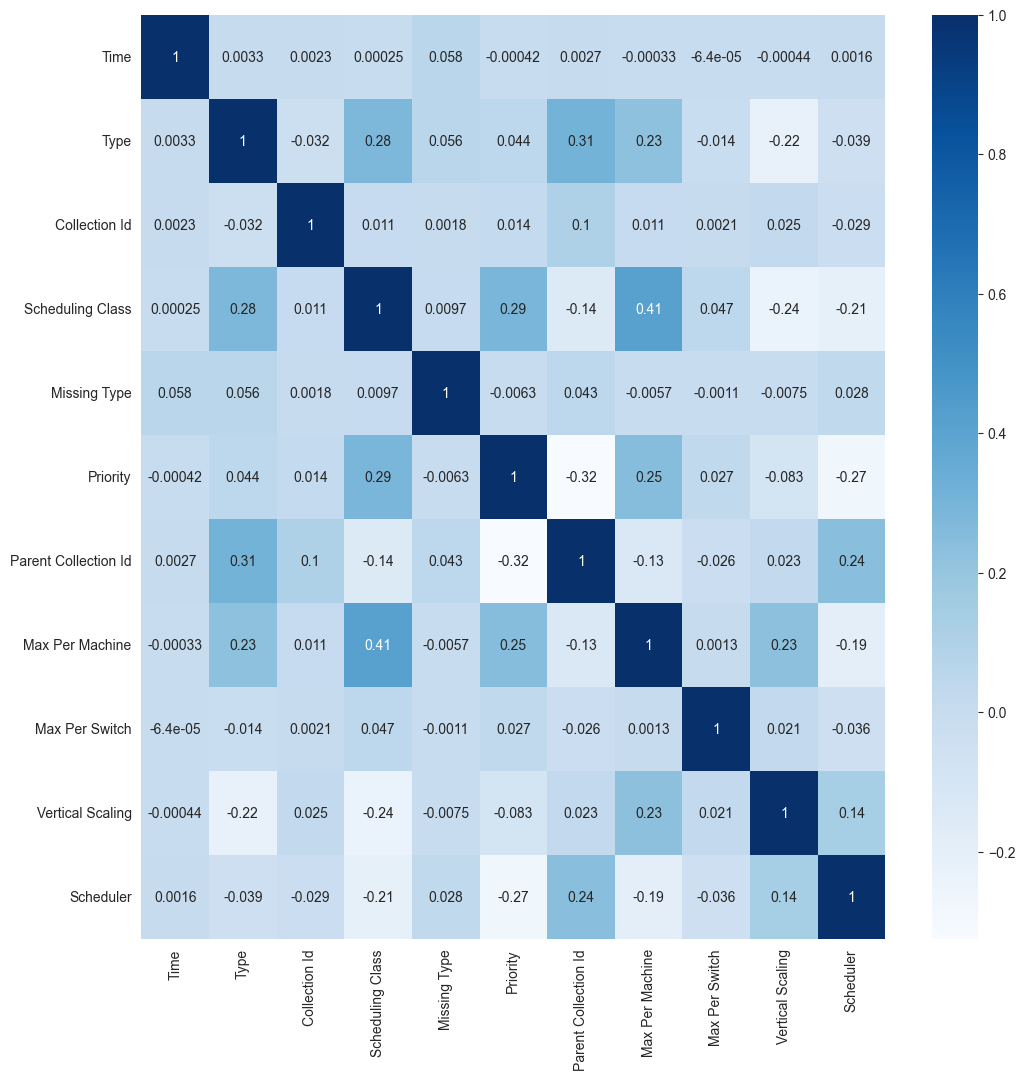

In [6]:
# select only the data for the terminal states
successful_jobs_correlation_df = collection_events_df.filter(collection_events_df.type.isin(allowedEventTypes))

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=successful_jobs_correlation_df.columns, outputCol=vector_col)
df_vector = assembler.transform(successful_jobs_correlation_df).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

labels = ['Time', 'Type', 'Collection Id', 'Scheduling Class', 'Missing Type', 'Priority', 'Parent Collection Id',
          'Max Per Machine', 'Max Per Switch', 'Vertical Scaling', 'Scheduler']
plt.figure(figsize=(12, 12))
sb.heatmap(cor_np, xticklabels=labels, yticklabels=labels, cmap=sb.color_palette("Blues", as_cmap=True), annot=True)

## Tasks Visualisation Analysis

In [3]:
# Instance Events fields with nulls: missing_type, machine_id - fill missing values; resource_request - remove null entries; alloc_instance_index - remove
instance_events_df = instance_events_df.drop(*['alloc_collection_id', 'alloc_instance_index', 'constraint'])
instance_events_df = instance_events_df.na.drop(subset=["resource_request"])
instance_events_df = instance_events_df.fillna(0, subset=["machine_id"])
instance_events_df = instance_events_df.fillna(0, subset=["missing_type"])

instance_events_df = instance_events_df.withColumn('cpus', instance_events_df["resource_request.cpus"]).withColumn('memory', instance_events_df["resource_request.memory"])
instance_events_df = instance_events_df.drop("resource_request")
instance_events_df.printSchema()

root
 |-- time: long (nullable = true)
 |-- type: long (nullable = true)
 |-- collection_id: long (nullable = true)
 |-- scheduling_class: long (nullable = true)
 |-- missing_type: long (nullable = true)
 |-- priority: long (nullable = true)
 |-- instance_index: long (nullable = true)
 |-- machine_id: long (nullable = true)
 |-- cpus: double (nullable = true)
 |-- memory: double (nullable = true)



### Pie Chart

In [8]:
tasks_with_priorities_df = instance_events_df.withColumn('priority_range', F.when(instance_events_df.priority <= 99, 'Free tier').
                                                         when(instance_events_df.priority.between(100, 115), 'Best-effort Batch').when(instance_events_df.priority.between(116, 119), 'Mid-tier').
                                                         when(instance_events_df.priority.between(120, 359), 'Production tier').when(instance_events_df.priority >= 360, 'Monitoring tier')
                                                         ).select('priority_range')

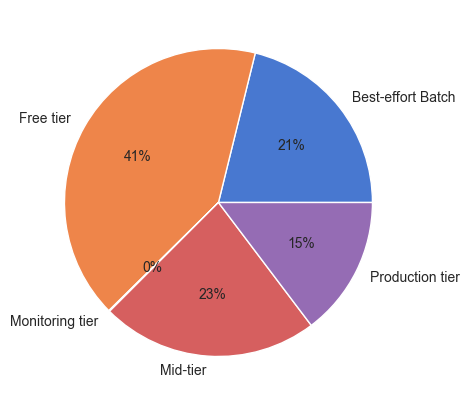

In [9]:
tasks_pie_count_rows = tasks_with_priorities_df.groupby("priority_range").count().collect()

labels = [row["priority_range"] for row in tasks_pie_count_rows]
counts = [row["count"] for row in tasks_pie_count_rows]

plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, colors=sb.color_palette('muted'), autopct='%.0f%%')
plt.show()

### Heatmap

<Axes: >

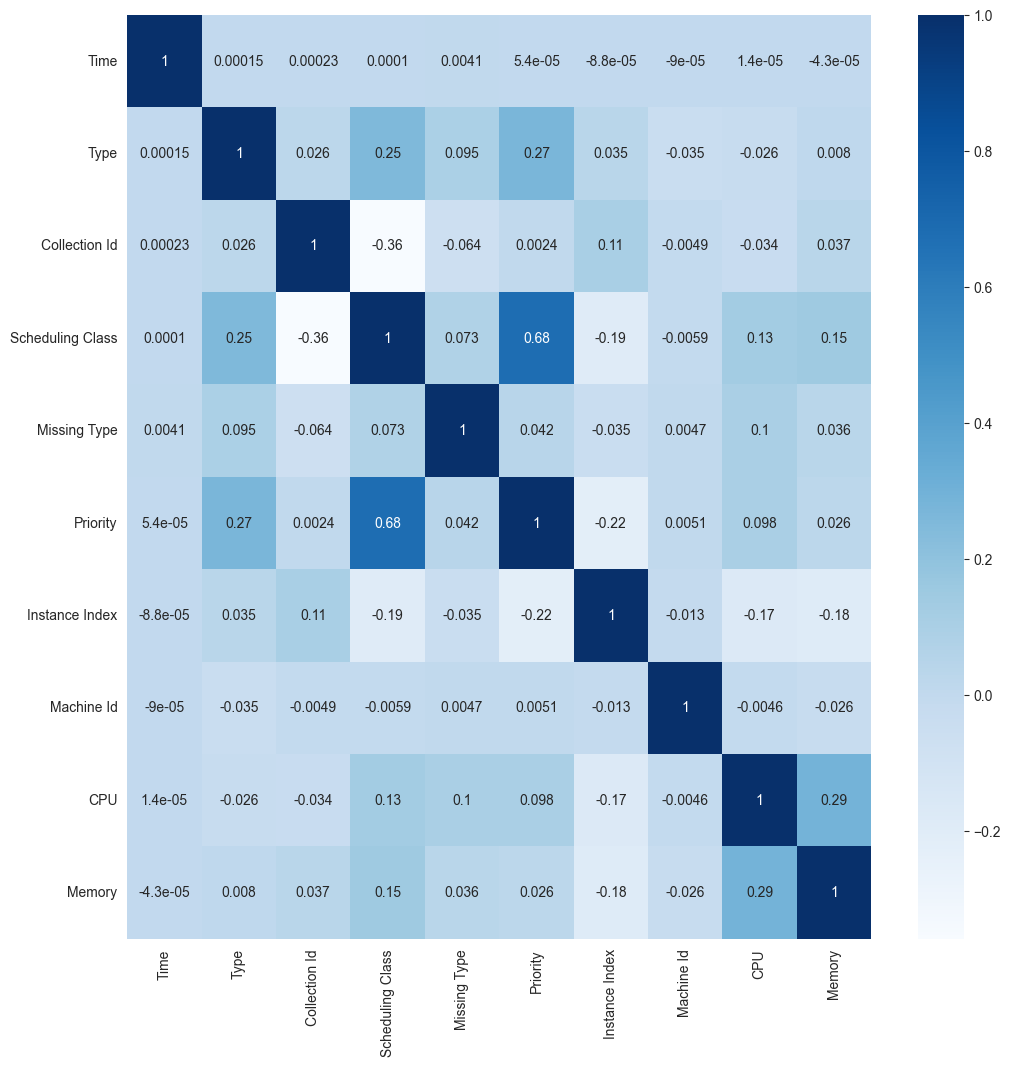

In [4]:
# select only the data for the terminal states
successful_tasks_correlation_df = instance_events_df.filter(instance_events_df.type.isin(allowedEventTypes))

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=successful_tasks_correlation_df.columns, outputCol=vector_col)
df_vector = assembler.transform(successful_tasks_correlation_df).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

labels = ['Time', 'Type', 'Collection Id', 'Scheduling Class', 'Missing Type', 'Priority', 'Instance Index',
          'Machine Id', 'CPU', 'Memory']
plt.figure(figsize=(12, 12))
sb.heatmap(cor_np, xticklabels=labels, yticklabels=labels, cmap=sb.color_palette("Blues", as_cmap=True), annot=True)